<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/Multi_neuron_exp2_rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
class TwoLayerNN(nn.Module):
  def __init__(self, m, d): # fix the second layer to be half 1 and half -1
    super().__init__()
    self.fc1_pos = nn.Linear(d, m, bias=False)
    self.fc1_neg = nn.Linear(d, m, bias=False)
    self.fc2_pos = torch.ones([m, 1])
    self.fc2_neg = -1 * torch.ones([m, 1])


  def activation(self, x): # cubic activation
    return x.clamp(min=0)

  def forward(self, x):
    _out_pos = self.activation(self.fc1_pos(x))
    out_pos = torch.matmul(_out_pos, self.fc2_pos)

    _out_neg = self.activation(self.fc1_neg(x))
    out_neg = torch.matmul(_out_neg, self.fc2_neg)

    return out_pos + out_neg

In [3]:
n = 30
D_in = 2
D_out = 1
m = 30
l0_threshold_grad_matrix = 0.0001

def get_data(n, d): # set data to be y * w + noise
  y = torch.cat((torch.ones(n // 2, 1), -torch.ones(n // 2, 1)), dim=0)
  w = torch.zeros(1, d)
  w[0,0] = 0.3

  X = torch.cat((w.repeat(n//2, 1), -w.repeat(n//2, 1)), dim=0)
  X = X + torch.randn(X.shape)/d**0.5

  return X, y

In [4]:
x, y = get_data(n, D_in)
model =  TwoLayerNN(m, D_in)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, weight_decay=0)
criteria = nn.MSELoss()

In [5]:
def weights_init(m):
  for p in m.parameters():
    nn.init.xavier_uniform_(p, gain=.1)

# def train(epochs, lr):
#   model =  TwoLayerNN(m, D_in)
#   model.apply(weights_init)
#   optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)

#   model.train()
#   res = []
#   for epoch in range(epochs):
#     output = model(x)
#     loss = criteria(output, y)

#     optimizer.zero_grad()
#     loss.backward()

#     optimizer.step()

#     tmp = []
#     flag = 0
#     for p in model.parameters():
#       print(np.linalg.matrix_rank(p.data.numpy()))
#       tmp += np.linalg.matrix_rank(p.data.numpy())
#       break;
#       # tmp += [(p.clone().detach()**2).sum(dim=-1).numpy()]

#     res += [tmp]
#     if epoch % 100 == 0:
#       print (epoch, loss.item())

#   return np.array(res)
def train(epochs, lr):
  train_loss, nets_avg = [], []
  model = TwoLayerNN(m, D_in)
  model.apply(weights_init)
  net, net_avg = copy.deepcopy(model), copy.deepcopy(model)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0, weight_decay=0)
  net.train()

  for epoch in range(epochs):
    output = net(x)
    loss = criteria(output, y)
    if epoch % 100 == 0:
      print (epoch, loss.item())
    train_loss += [loss.item()]
    nets_avg.append(copy.deepcopy(net))

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  return train_loss, nets_avg

In [6]:
def compute_grad_matrix(net, X):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0)
    grad_matrix_list = []
    for i in range(X.shape[0]):
        h = net(X[[i]])
        optimizer.zero_grad()
        h.backward()

        grad_total_list = []
        for param in net.parameters():
            grad_total_list.append(param.grad.flatten().data.numpy())
        grad_total = np.concatenate(grad_total_list)
        grad_matrix_list.append(grad_total)

    grad_matrix = np.vstack(grad_matrix_list)
    return grad_matrix

def compute_grad_matrix_ranks(nets, X, l0_threshold_grad_matrix=0.0001):
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = X[:n_params]
    grad_matrix_ranks = []
    for net in nets:
        svals = np.linalg.svd(compute_grad_matrix(net, X_eval))[1]
        rank = (svals / svals[0] > l0_threshold_grad_matrix).sum()
        grad_matrix_ranks.append(rank)
    return grad_matrix_ranks

In [7]:
lr_small = 0.005
loss_small, net_small = train(15000, lr=lr_small)

0 0.9850605130195618
100 0.6828123927116394
200 0.6727746725082397
300 0.6689972281455994
400 0.6665168404579163
500 0.6646836996078491
600 0.6630426049232483
700 0.6616120934486389
800 0.6602073907852173
900 0.658933699131012
1000 0.6576400399208069
1100 0.6563987135887146
1200 0.6552402377128601
1300 0.6540471911430359
1400 0.6529228091239929
1500 0.6518304347991943
1600 0.6507378220558167
1700 0.6496838927268982
1800 0.6486661434173584
1900 0.6476524472236633
2000 0.6466951966285706
2100 0.6457049250602722
2200 0.6447791457176208
2300 0.6438501477241516
2400 0.642968475818634
2500 0.6420822143554688
2600 0.6411951184272766
2700 0.6403654217720032
2800 0.6395372152328491
2900 0.6387234330177307
3000 0.6379057765007019
3100 0.6371253728866577
3200 0.6363603472709656
3300 0.6356183290481567
3400 0.6348907947540283
3500 0.634197473526001
3600 0.6334818601608276
3700 0.6327853798866272
3800 0.6321258544921875
3900 0.6314622759819031
4000 0.6308224201202393
4100 0.630171000957489
4200 0.6

In [9]:
lr_large = 0.03
loss_large, net_large = train(15000, lr=lr_large)

0 1.0234543085098267
100 0.6665172576904297
200 0.6596493124961853
300 0.6537098288536072
400 0.6484884023666382
500 0.6438470482826233
600 0.639806866645813
700 0.6356633901596069
800 0.6316277980804443
900 0.6284724473953247
1000 0.6255511045455933
1100 0.6228771209716797
1200 0.6203665137290955
1300 0.6180222034454346
1400 0.6157999634742737
1500 0.6137160062789917
1600 0.6117174029350281
1700 0.6097683310508728
1800 0.6079423427581787
1900 0.6061453223228455
2000 0.6041027307510376
2100 0.6022549867630005
2200 0.600469172000885
2300 0.5987393856048584
2400 0.597132682800293
2500 0.5955647826194763
2600 0.5940268039703369
2700 0.5926560163497925
2800 0.5912787914276123
2900 0.5900266170501709
3000 0.5887756943702698
3100 0.5876381993293762
3200 0.5864922404289246
3300 0.5854006409645081
3400 0.5843067169189453
3500 0.5832895040512085
3600 0.5822046399116516
3700 0.58125901222229
3800 0.5802292227745056
3900 0.5792995095252991
4000 0.5783900618553162
4100 0.5774462819099426
4200 0.57

TwoLayerNN(
  (fc1_pos): Linear(in_features=2, out_features=30, bias=False)
  (fc1_neg): Linear(in_features=2, out_features=30, bias=False)
)


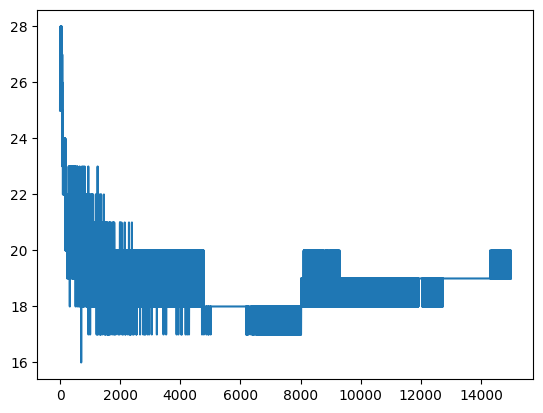

In [10]:
print(net_small[1])
n_params = sum([np.prod(param.shape) for param in net_small[-1].parameters()])
grad_matrix_ranks = compute_grad_matrix_ranks(net_small, x[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks)
# for i in range(m):
#   plt.xlim(0, 400)
#   plt.ylim(0, 0.15)
#   plt.plot(norm_small[::10, 0, i])
#   plt.title('lr={0}'.format(lr_small))
  #plt.plot(log2[::10, 1, i])

TwoLayerNN(
  (fc1_pos): Linear(in_features=2, out_features=30, bias=False)
  (fc1_neg): Linear(in_features=2, out_features=30, bias=False)
)


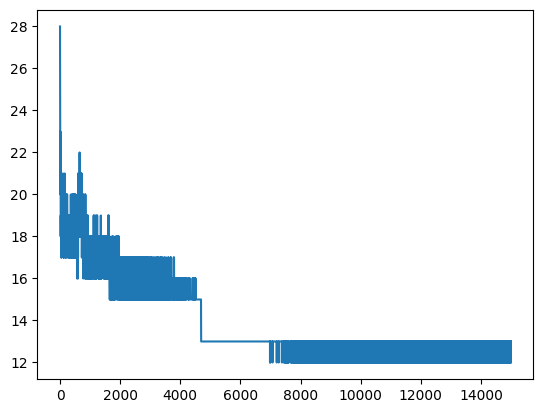

In [11]:
print(net_large[1])
n_params = sum([np.prod(param.shape) for param in net_large[-1].parameters()])
grad_matrix_ranks = compute_grad_matrix_ranks(net_large, x[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks)

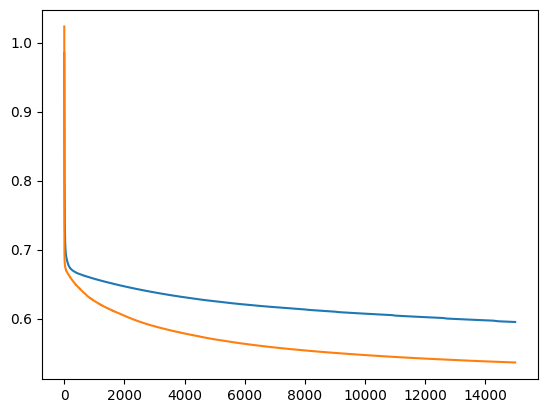

In [12]:
plt.plot(loss_small)
plt.plot(loss_large)